In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from collections import defaultdict
from pathlib import Path
import json
import random
import numpy as np
import math

In [4]:
from kg.utils.constants import ARTIFACTS_DIR
from kg.plotting.plotting import find_results_files, organize_results, plot_metric

In [4]:
base_experiments_dir = ARTIFACTS_DIR / "experiments_fmra"
layers_setting = "all_layers"
base_experiments_dir = base_experiments_dir / layers_setting

In [5]:
allow_smoke_test = False
all_my_results_files = find_results_files(base_experiments_dir, allow_smoke_test)

Found 123 'results.json' files.


In [14]:
top_k = 100
organized_results = organize_results(all_my_results_files, base_experiments_dir, top_k=top_k)

Attempted to parse 123 files.
Successfully parsed 123 paths and calculated metrics for 123.
Organized data into 1 datasets.


In [15]:
filtered_data = organized_results

In [16]:
core_patches_only = False
short_title = True
save = True

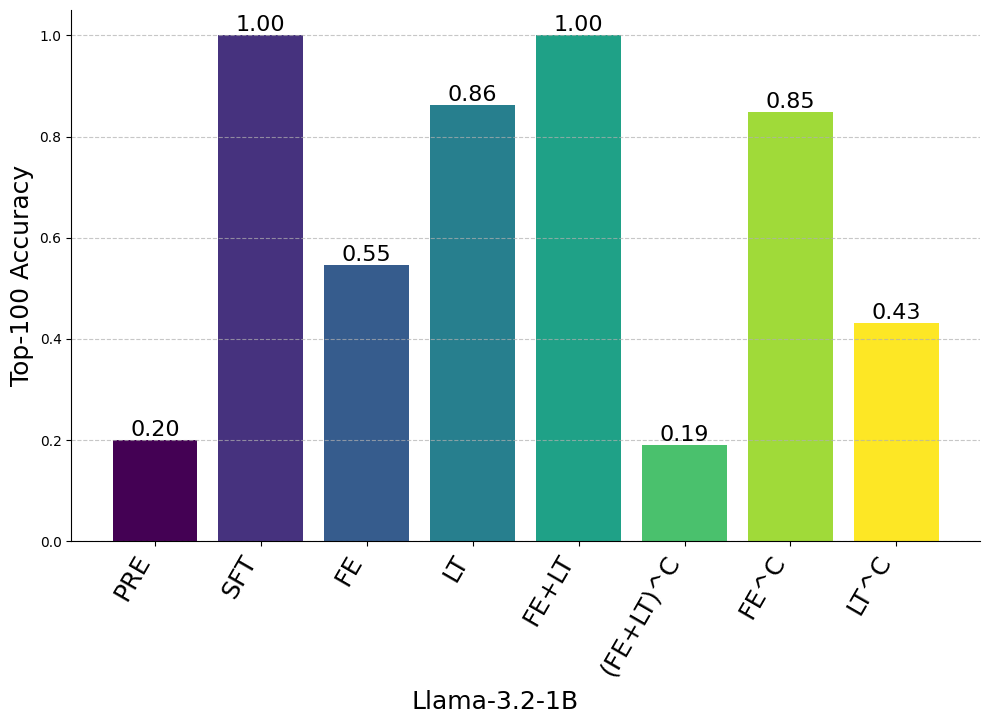

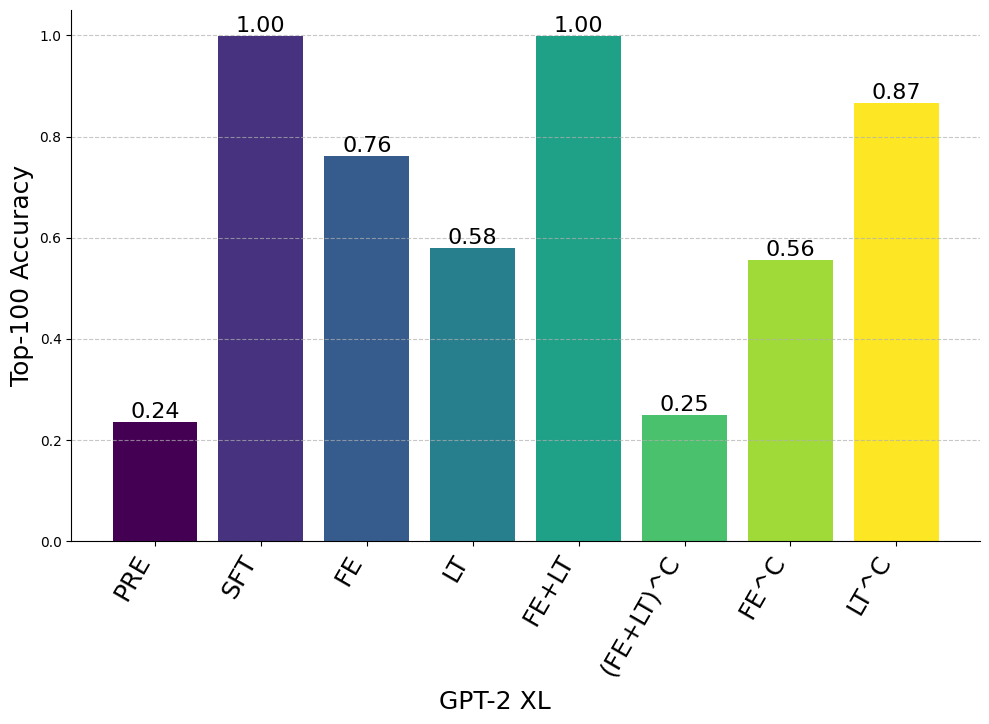

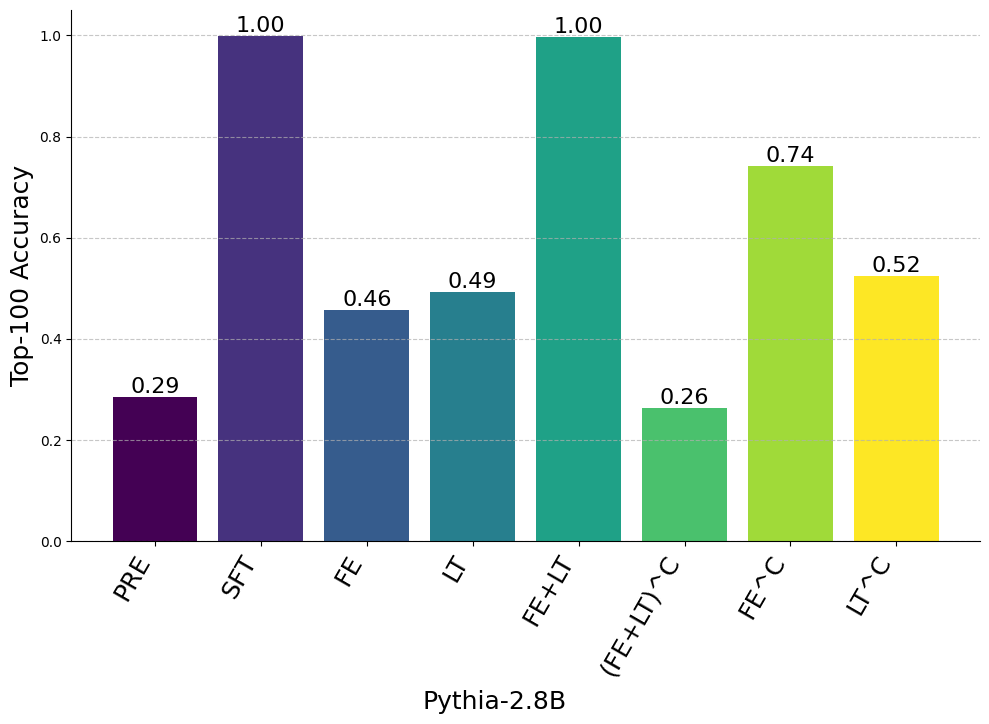

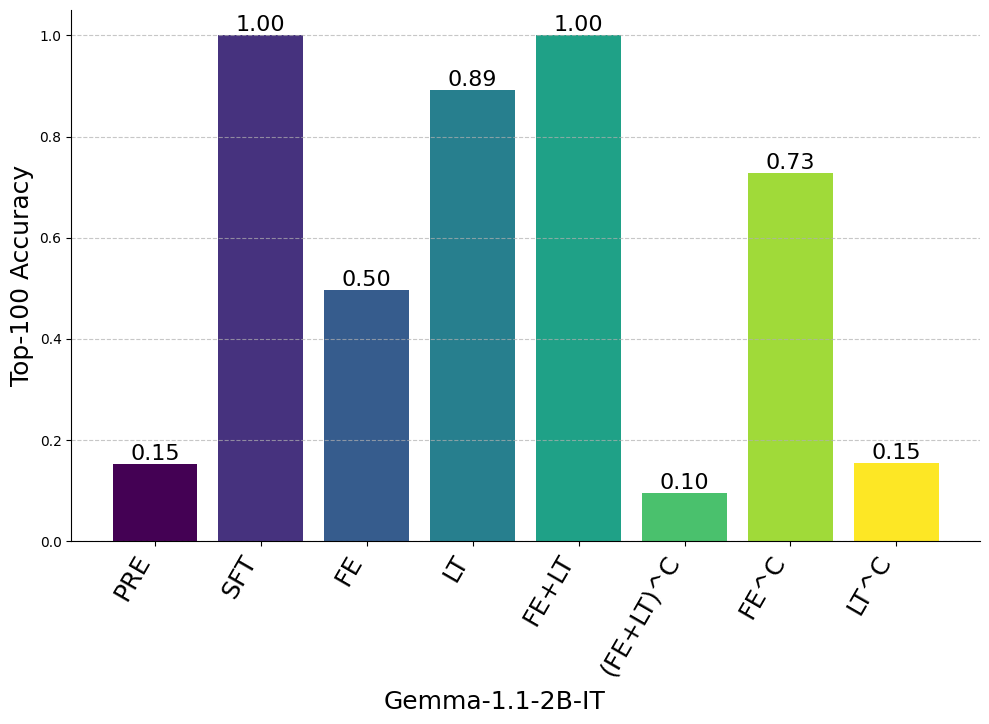

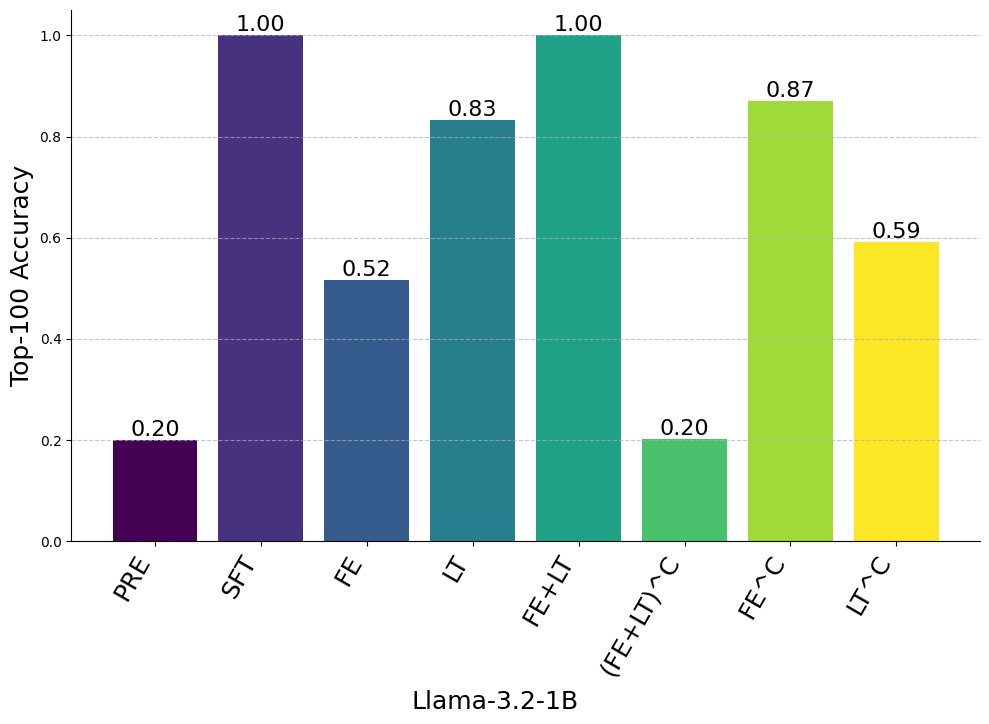

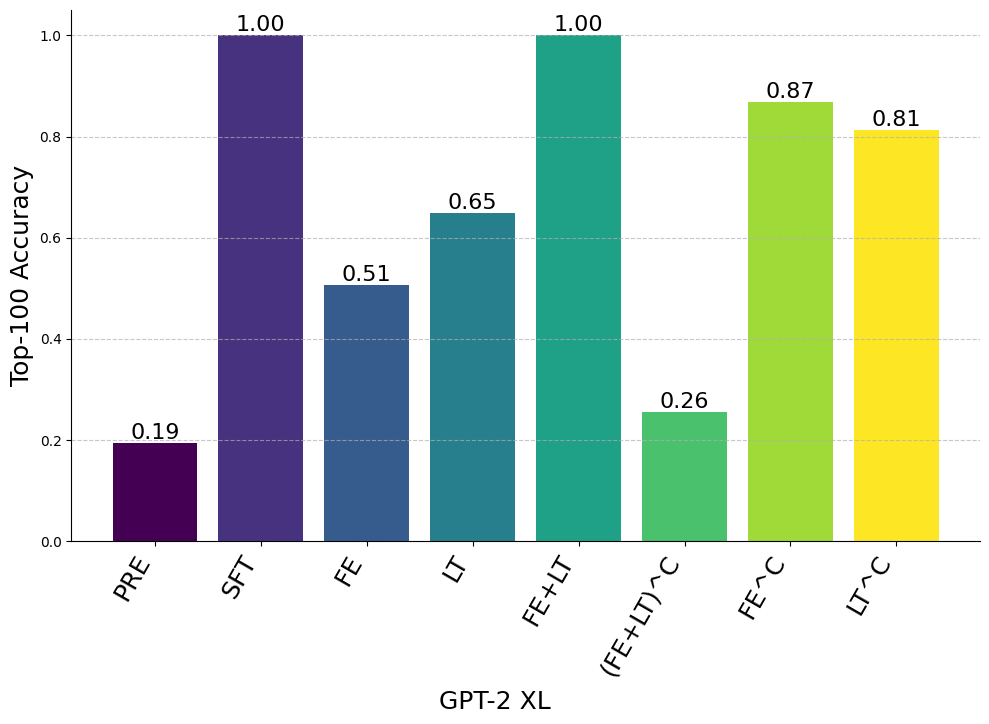

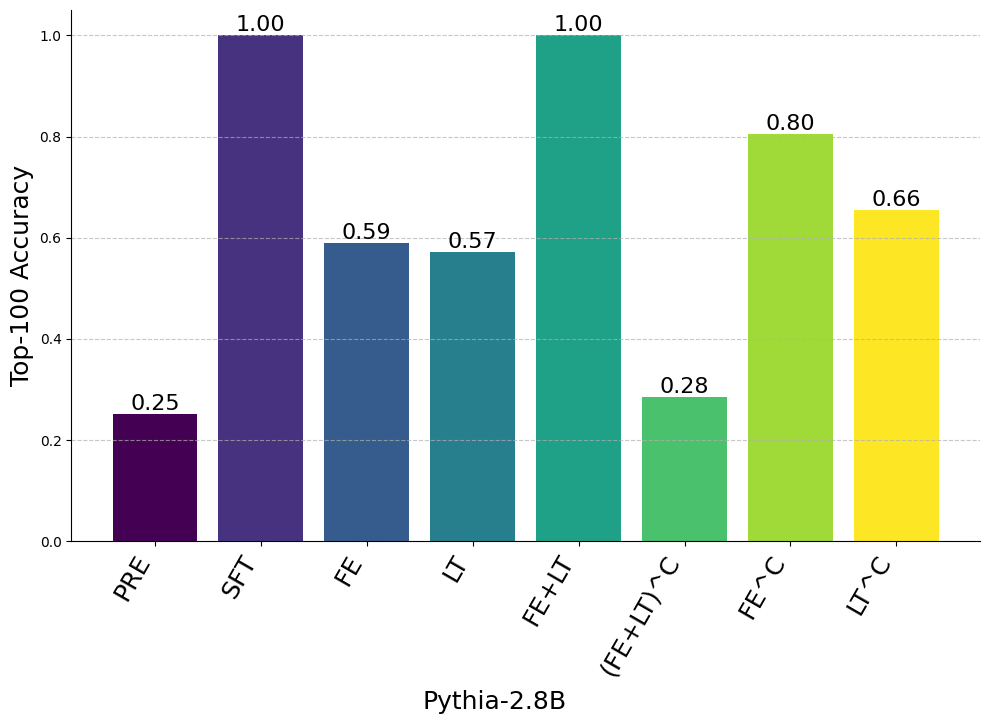

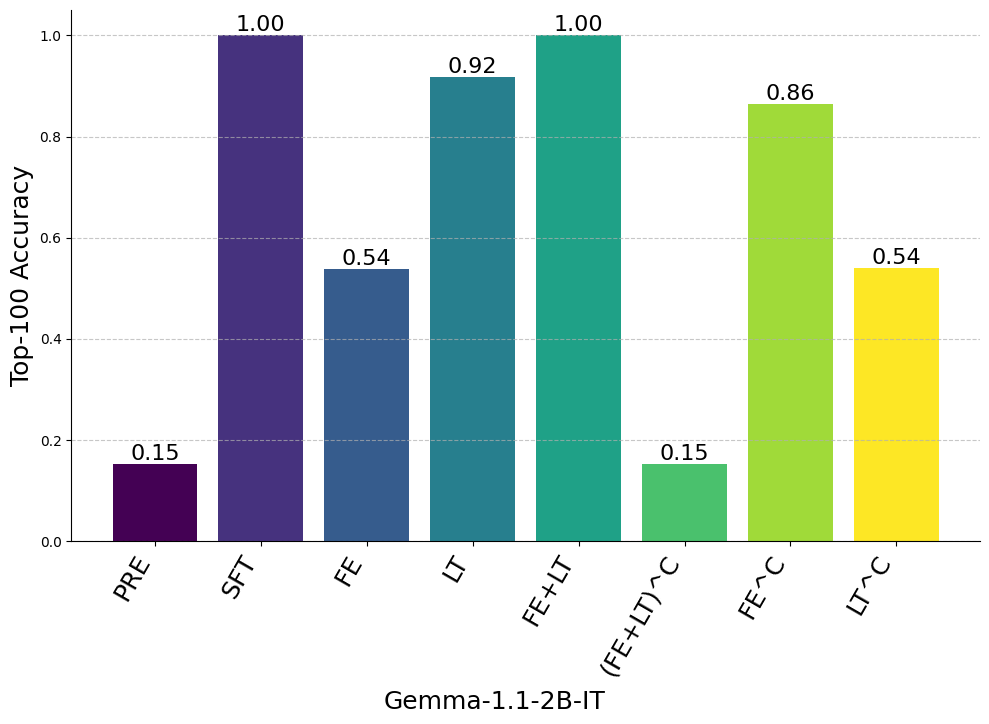

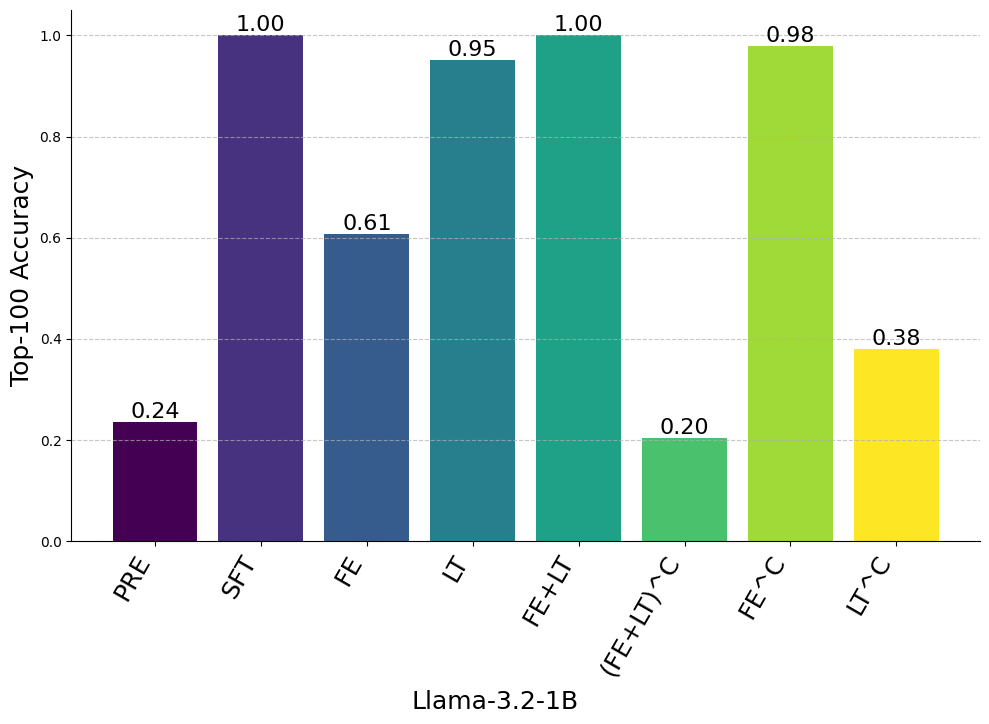

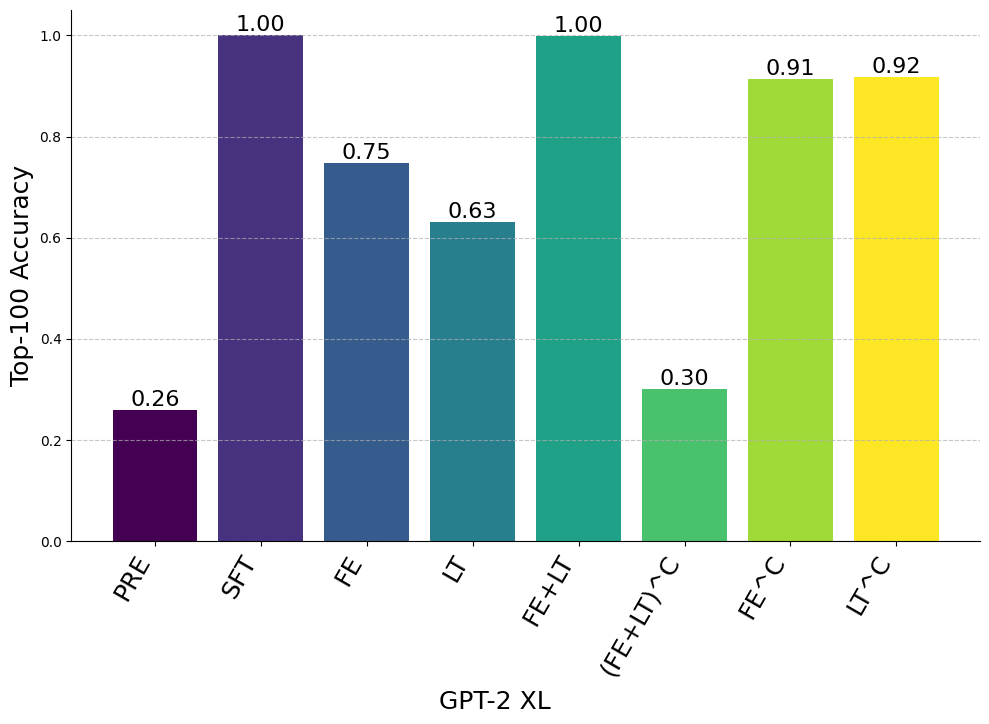

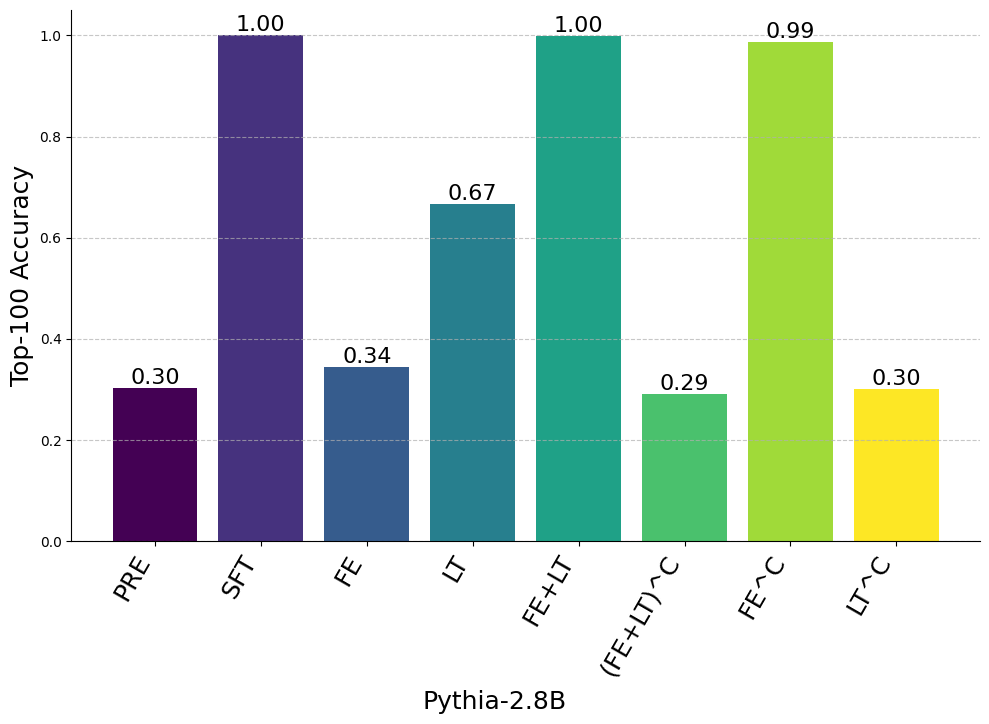

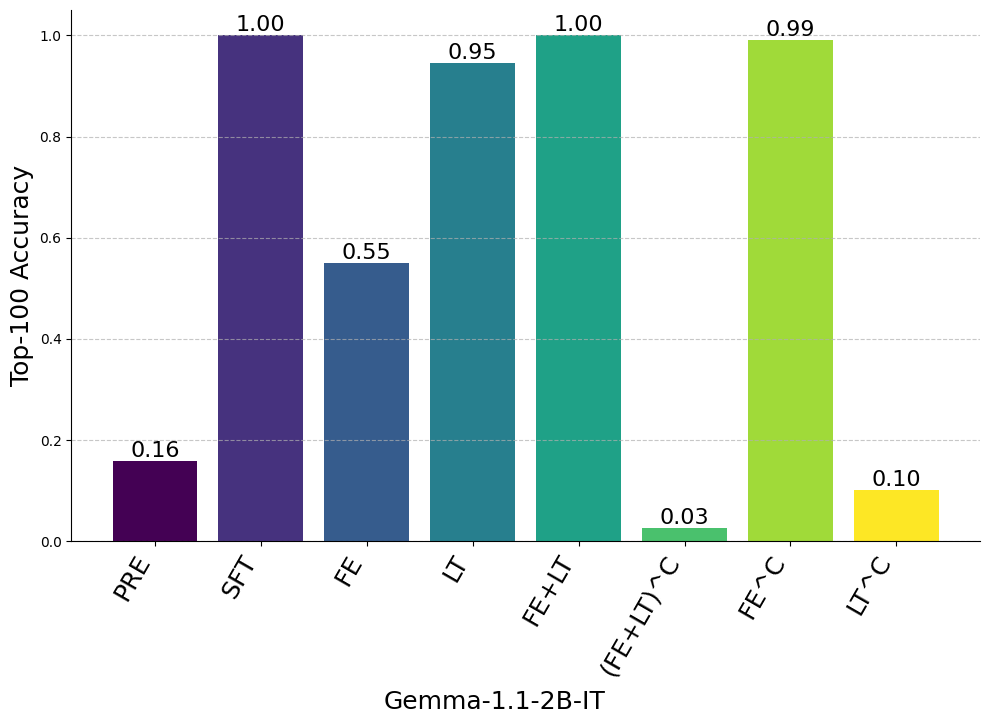

In [17]:
metric_key = "top_k_accuracy"
plot_metric(filtered_data, metric_key, layers_setting=layers_setting, save=save, core_patches_only=core_patches_only, short_title=short_title, top_k=top_k)

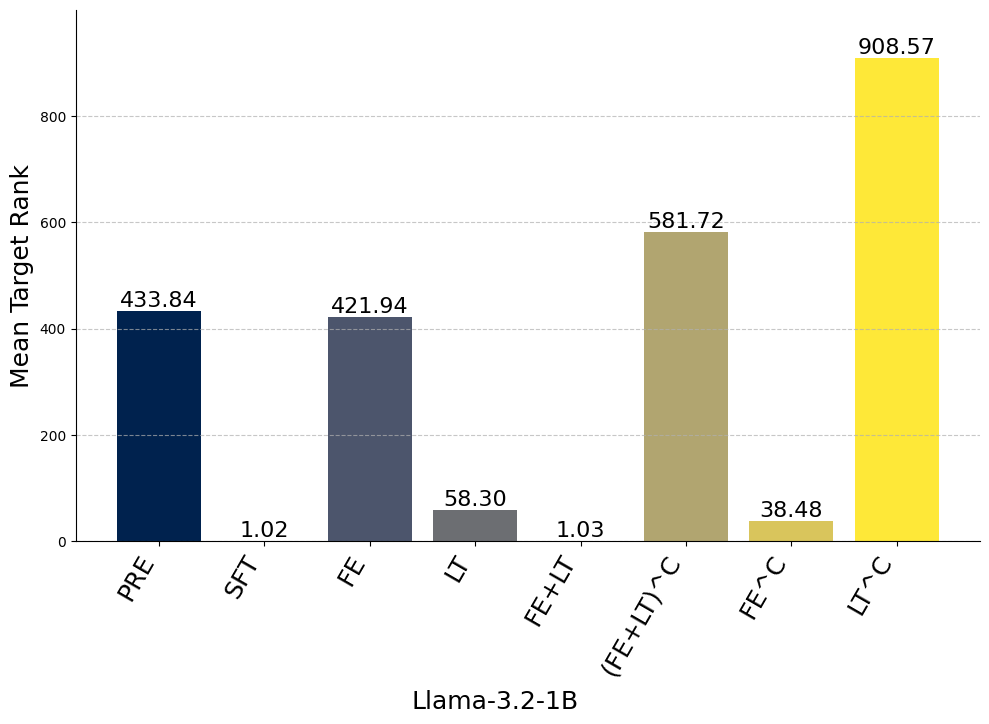

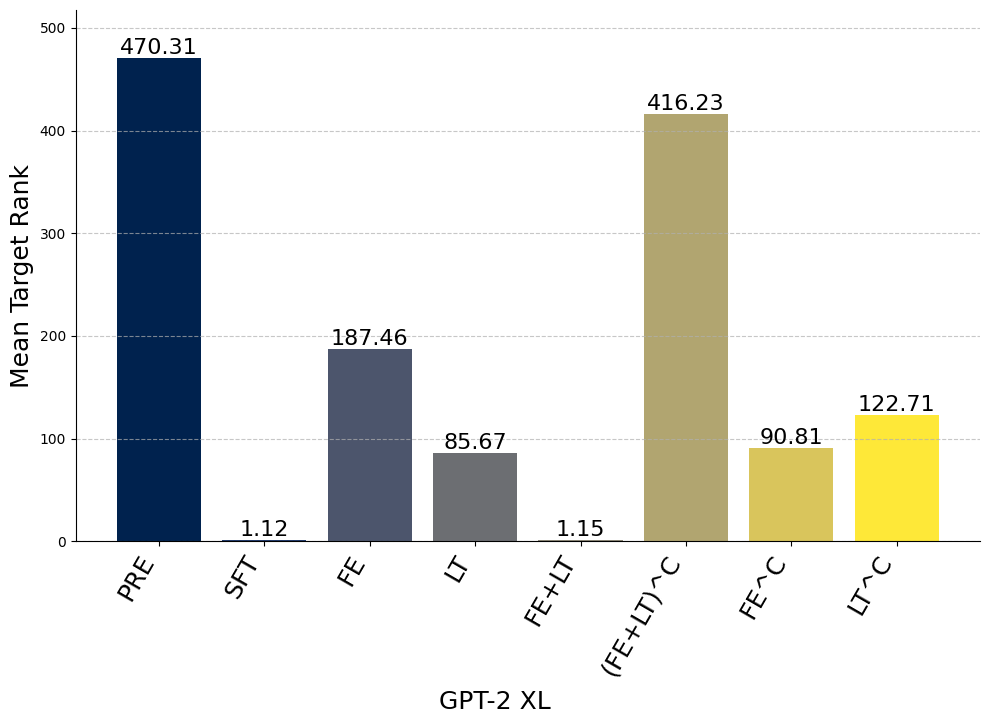

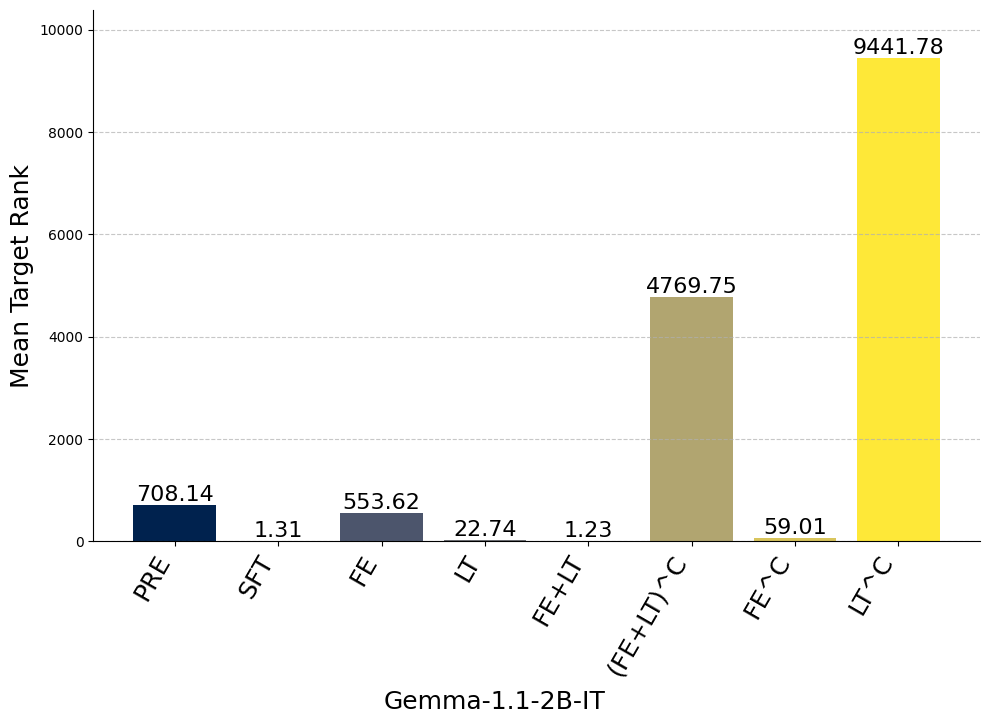

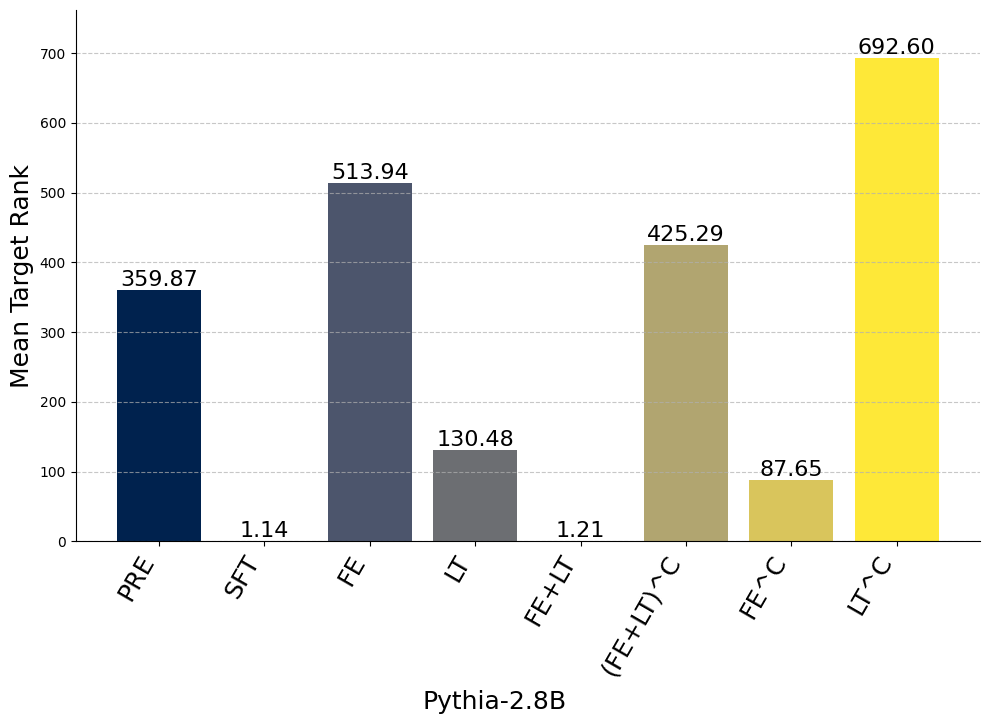

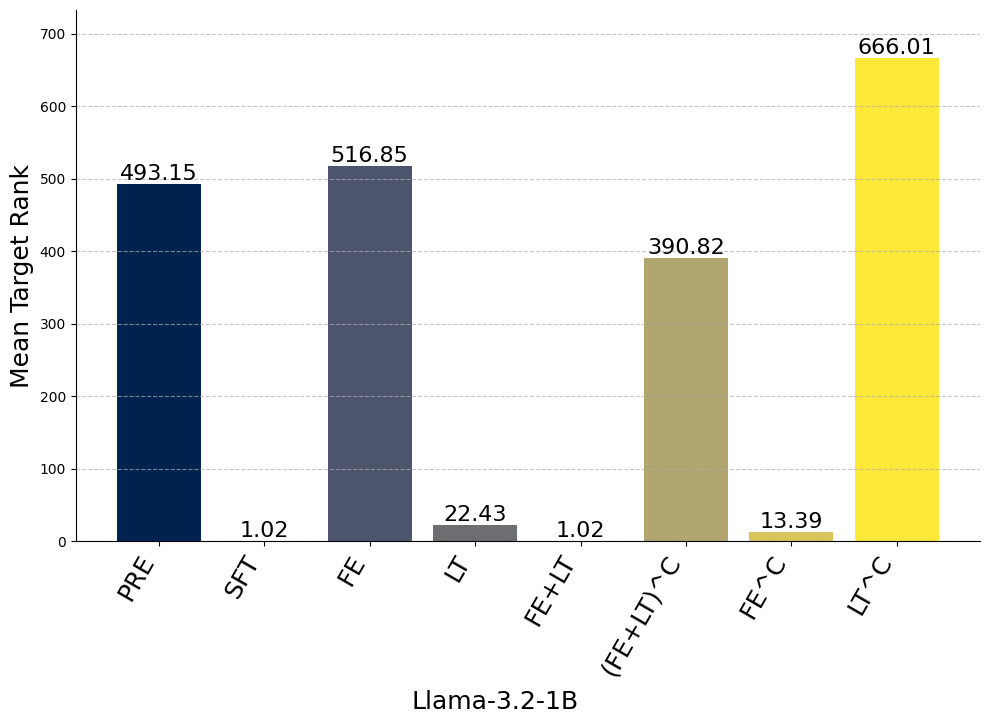

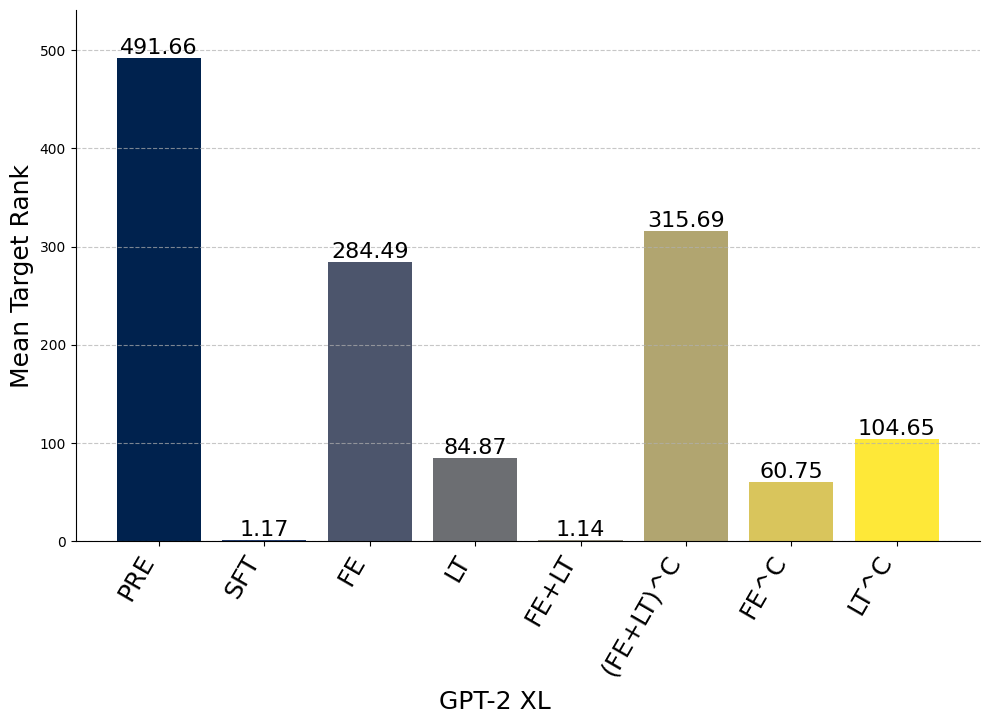

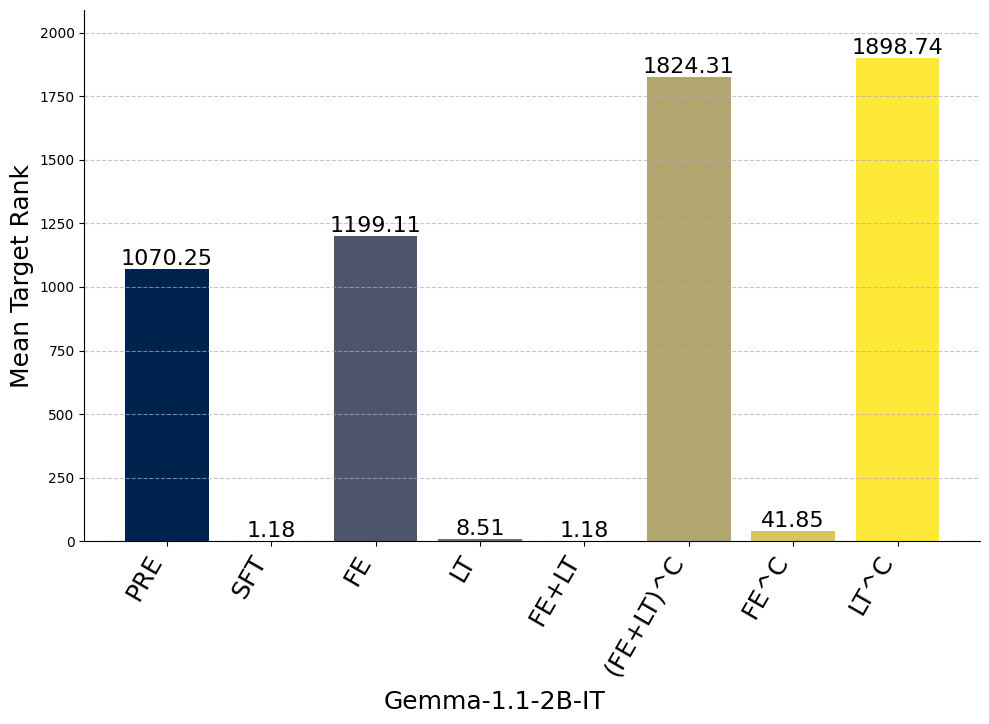

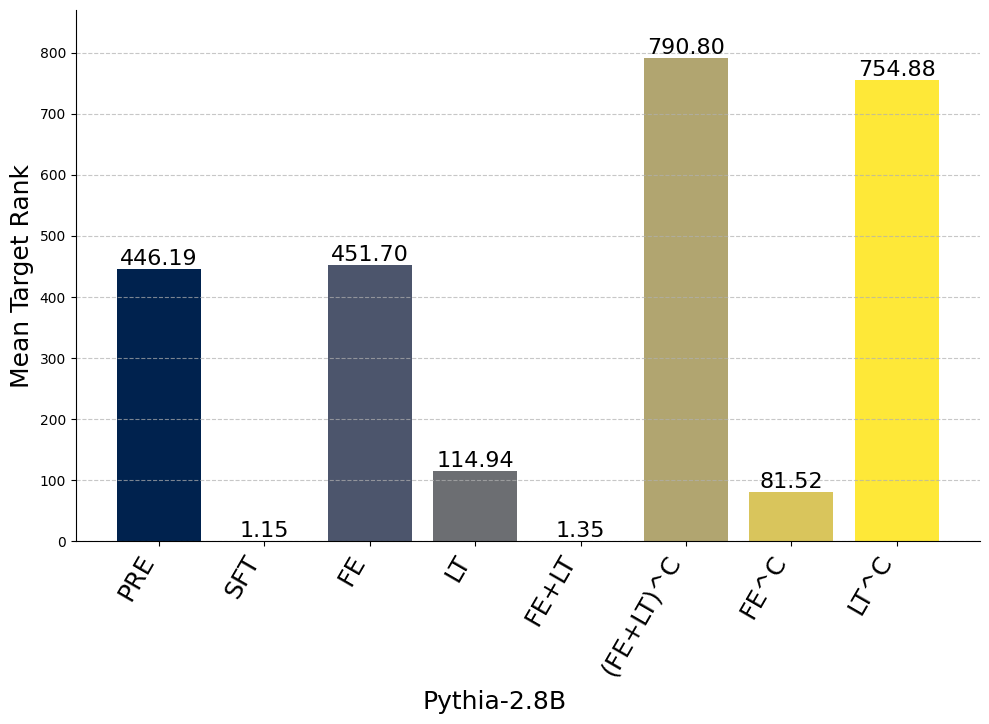

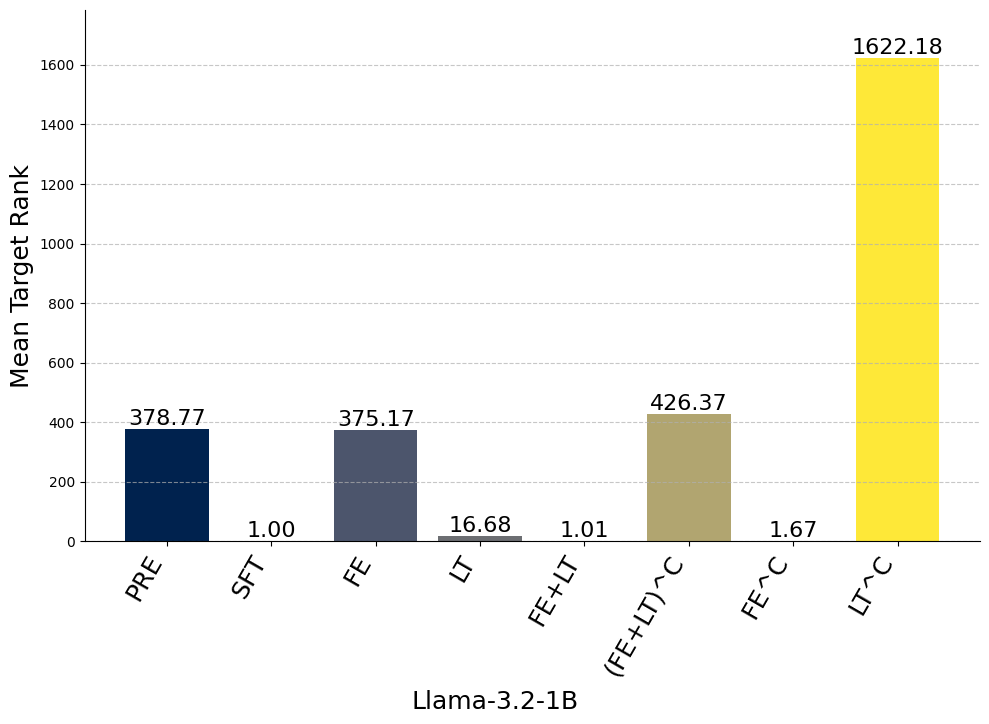

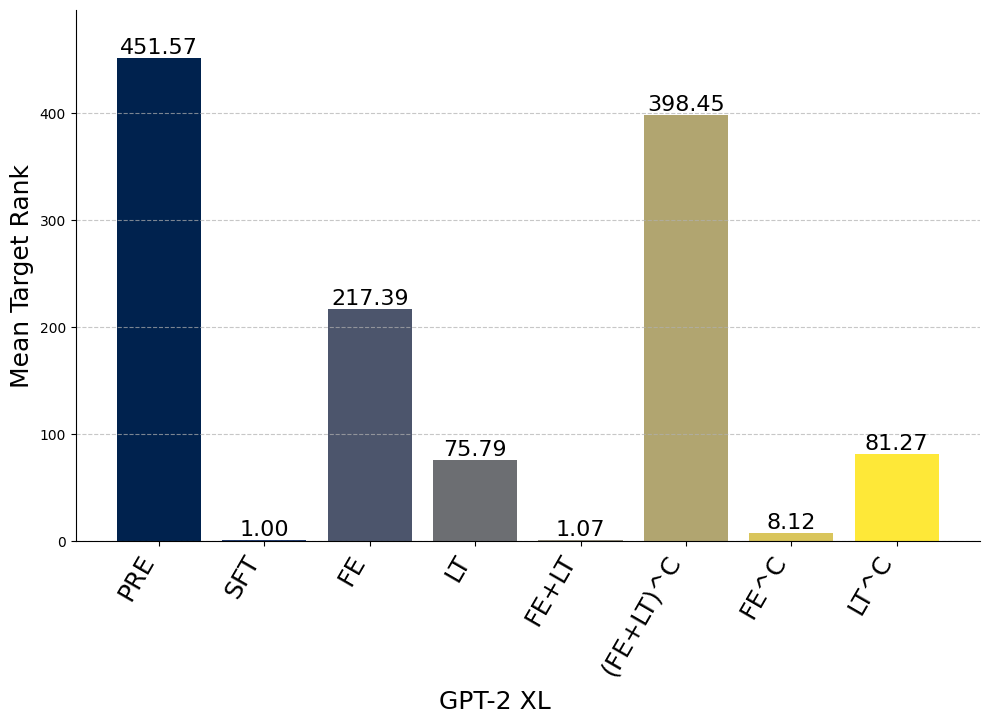

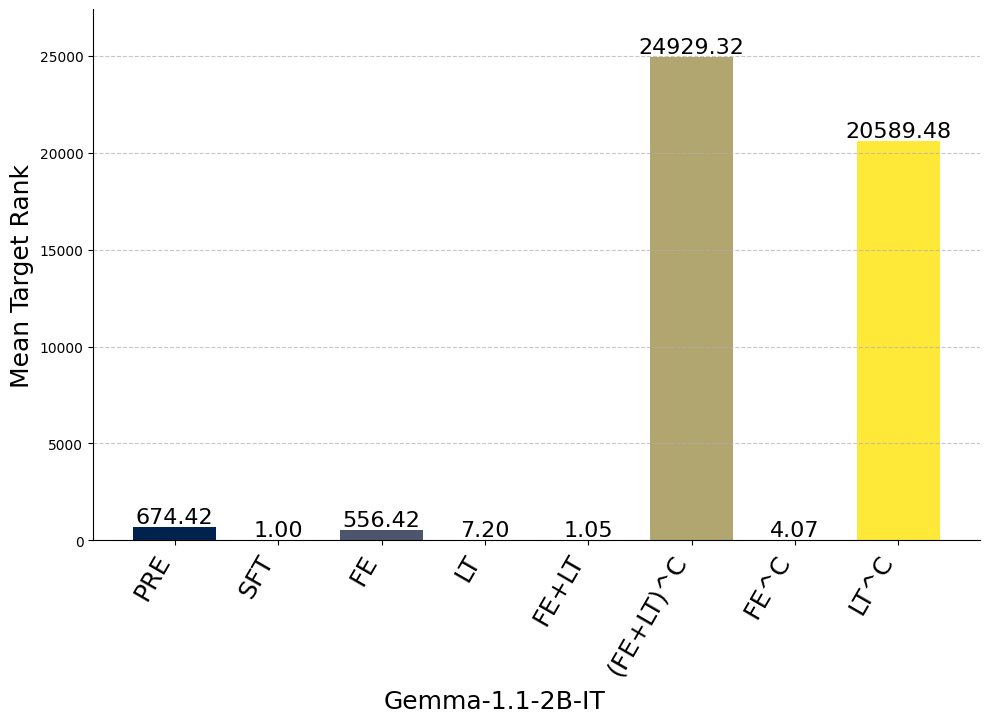

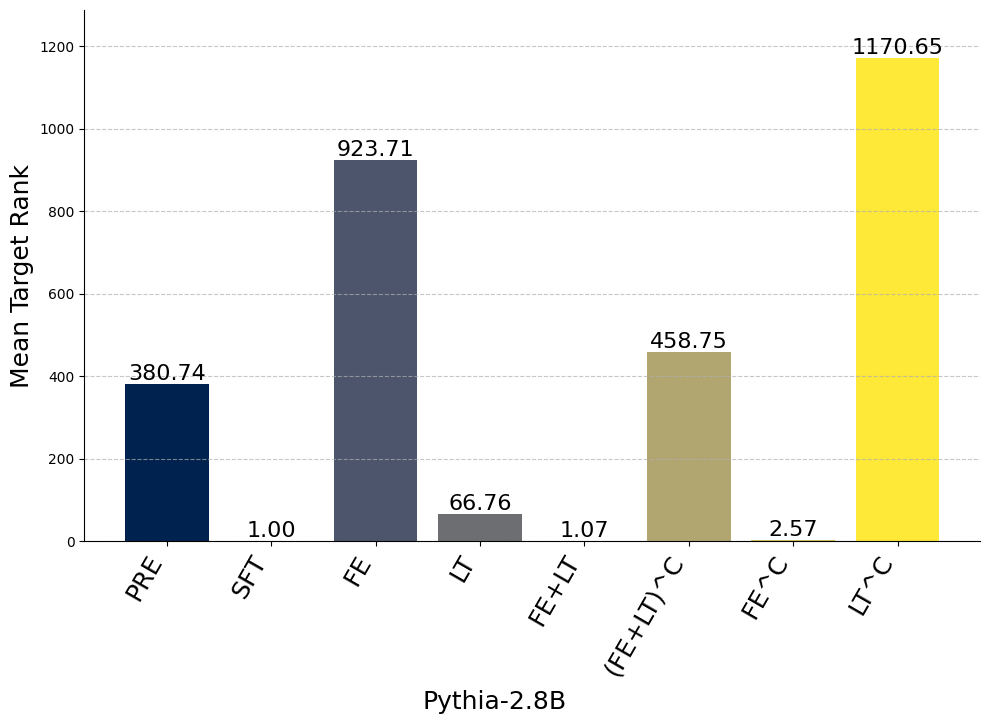

In [74]:
metric_key = "mean_target_rank"
plot_metric(organized_results, metric_key, layers_setting=layers_setting, save=save, core_patches_only=core_patches_only, short_title=short_title)

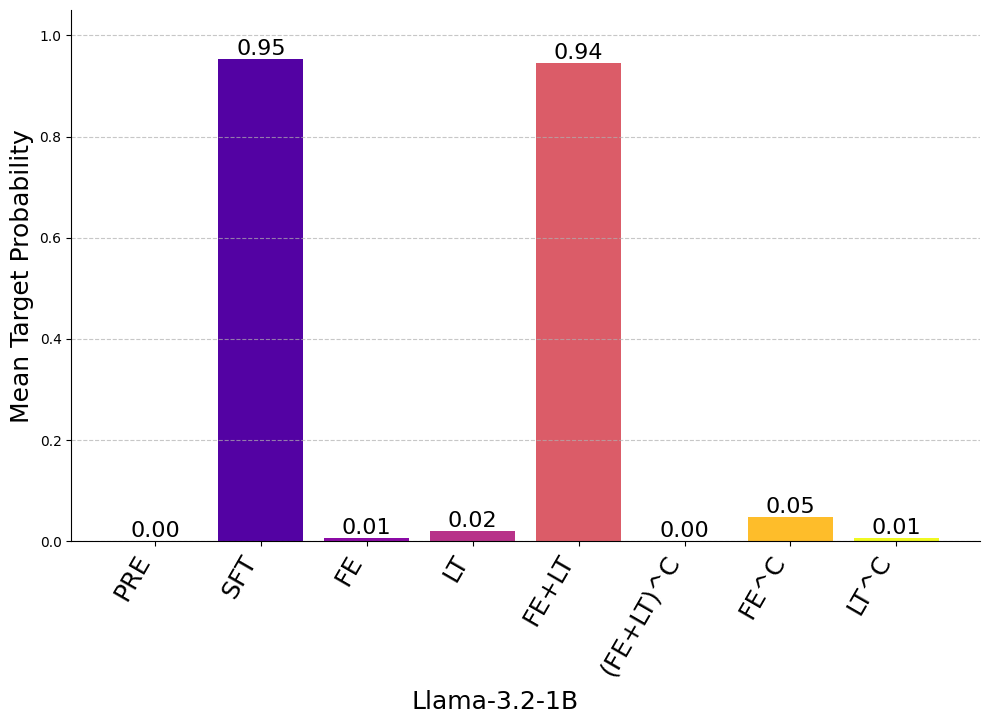

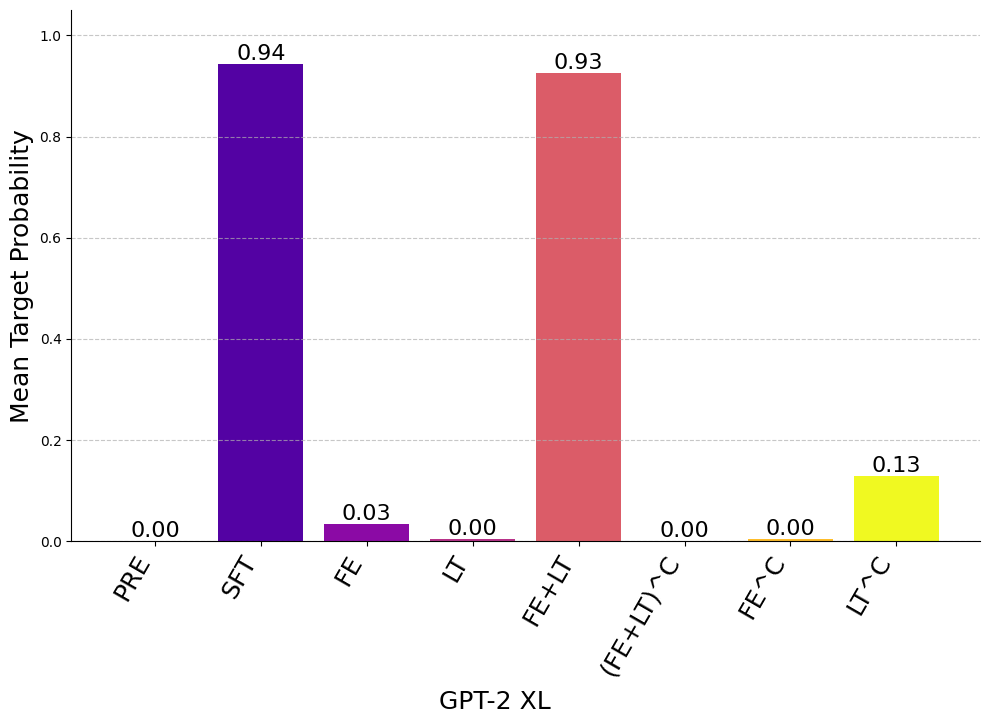

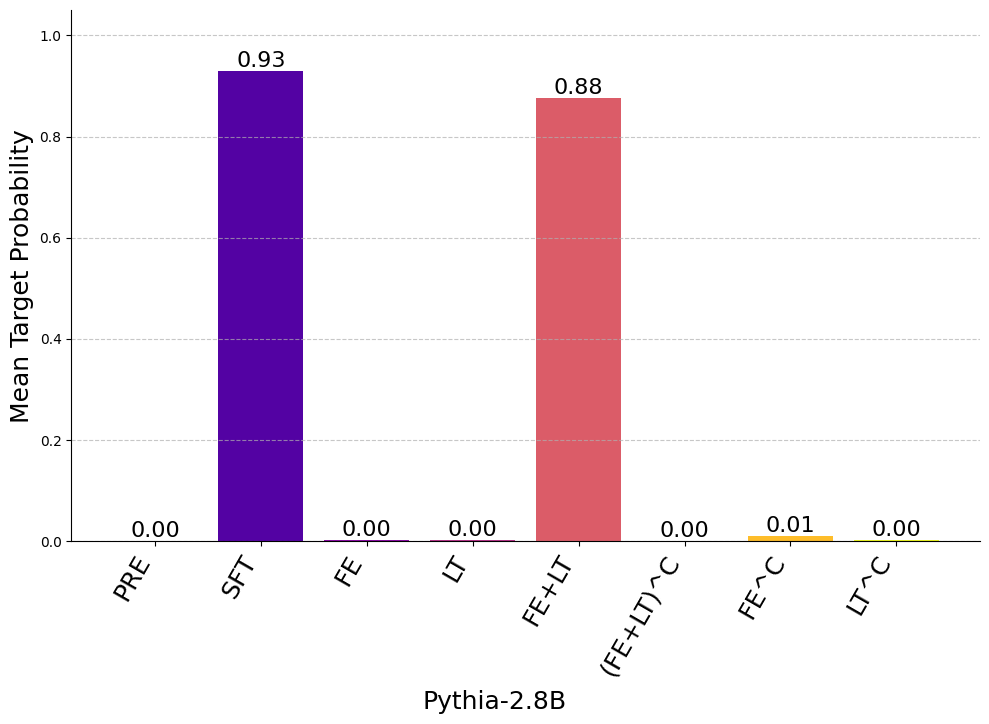

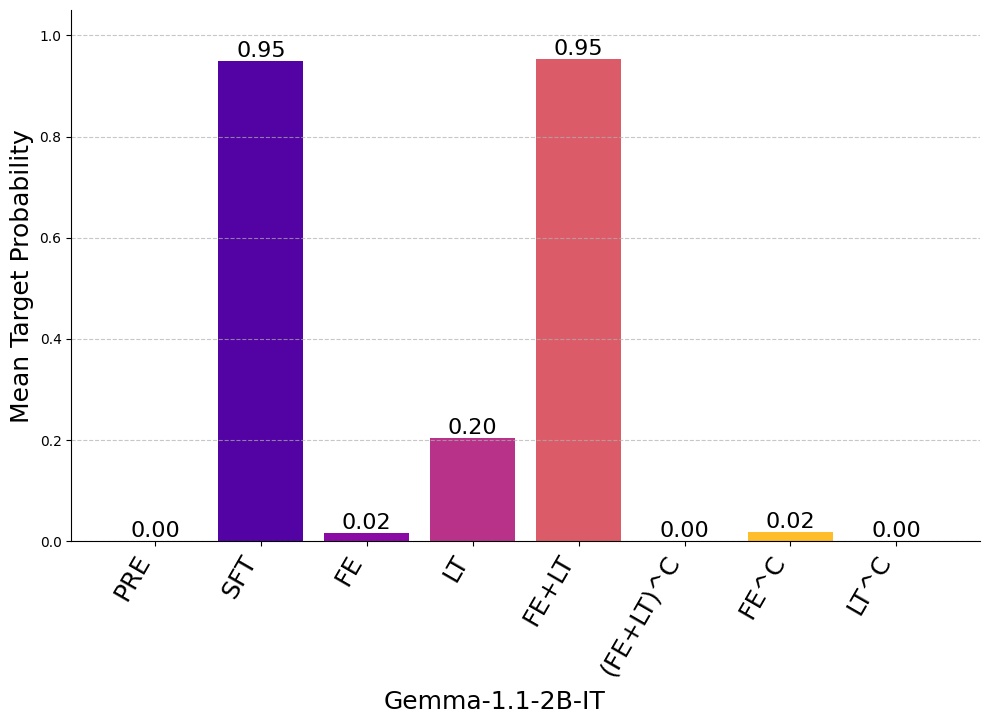

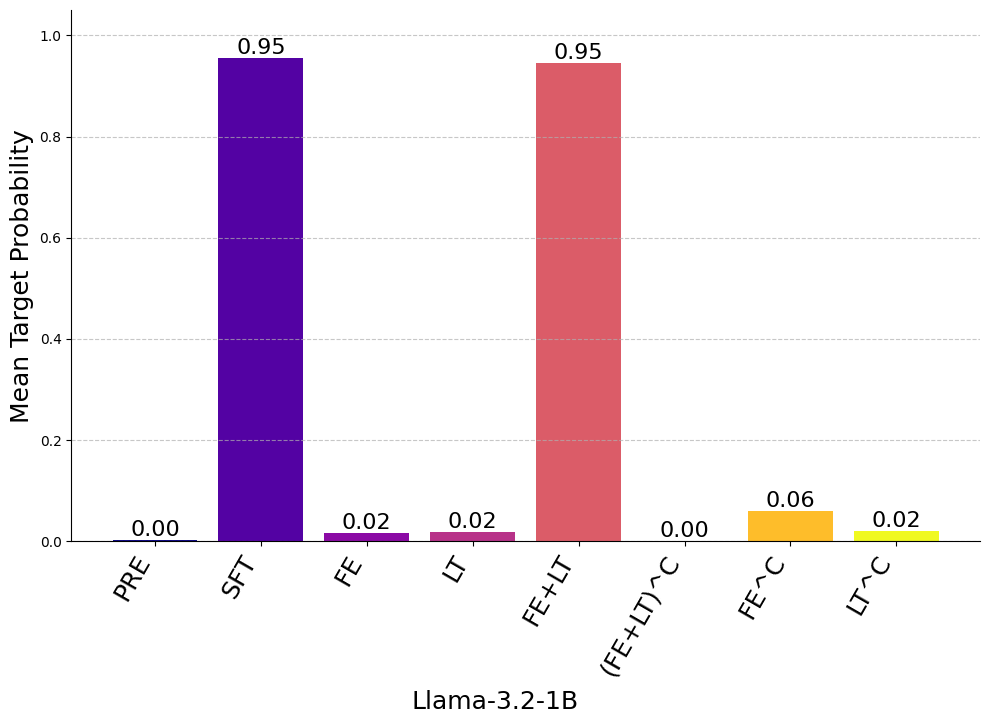

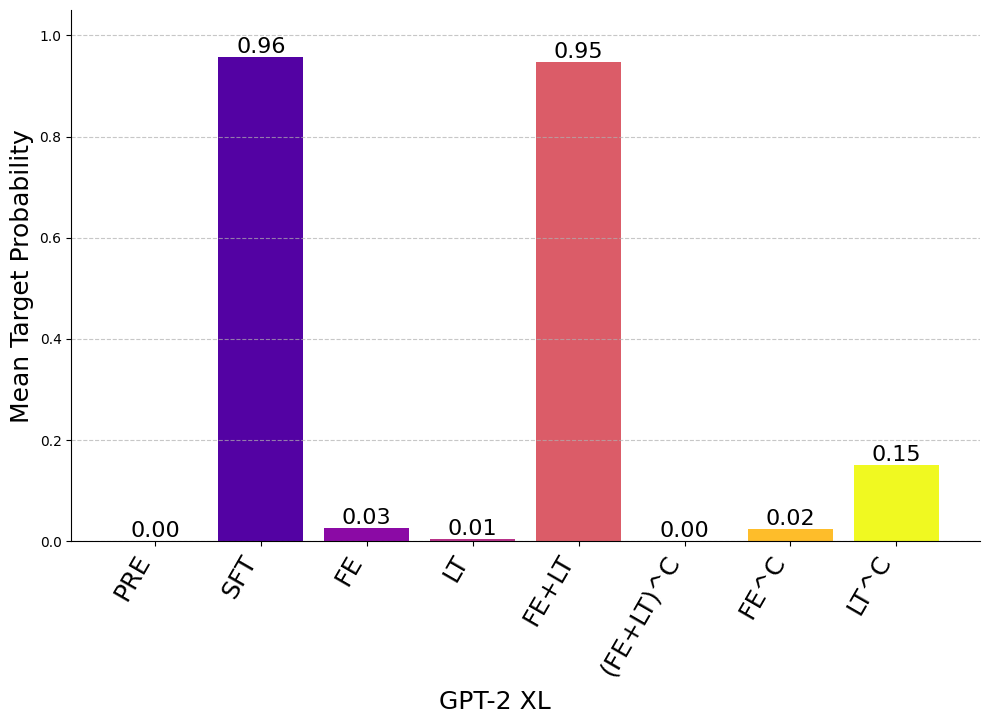

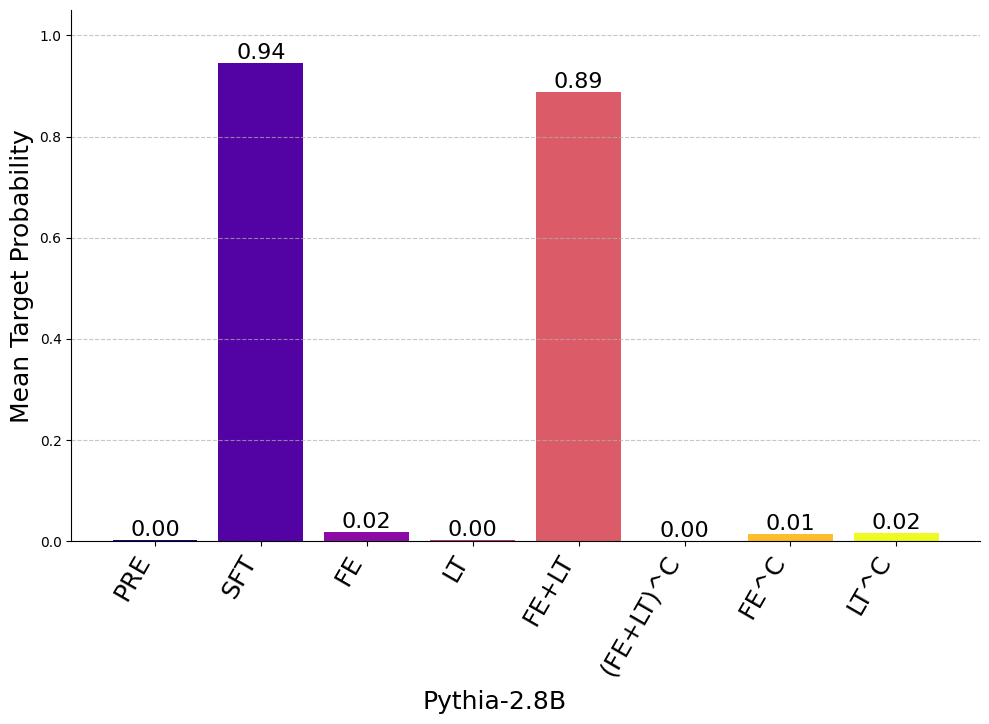

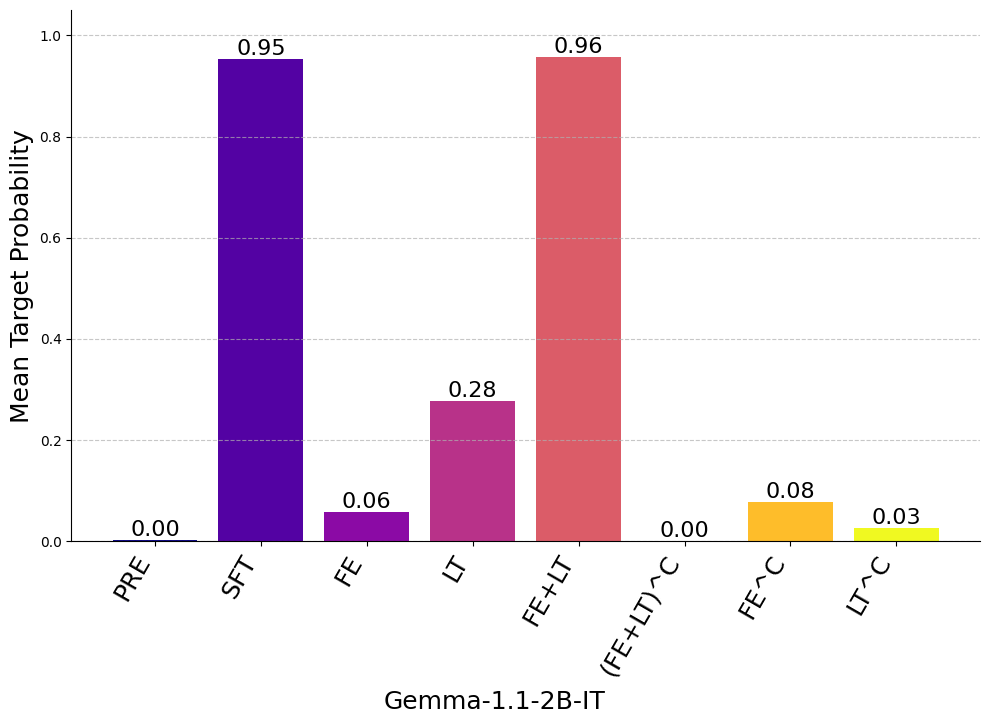

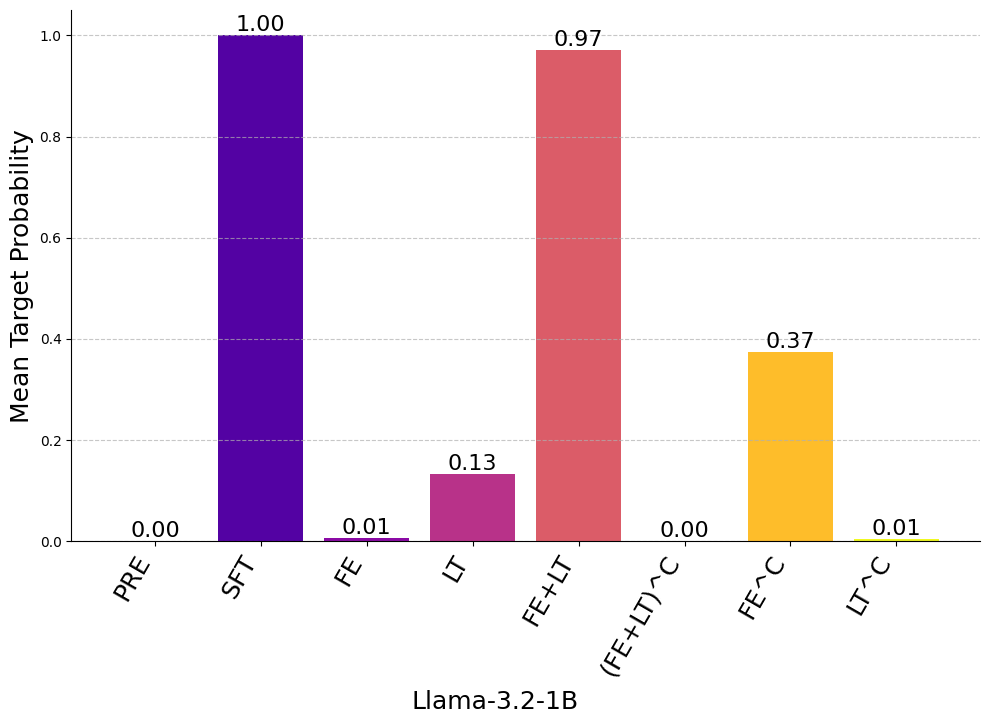

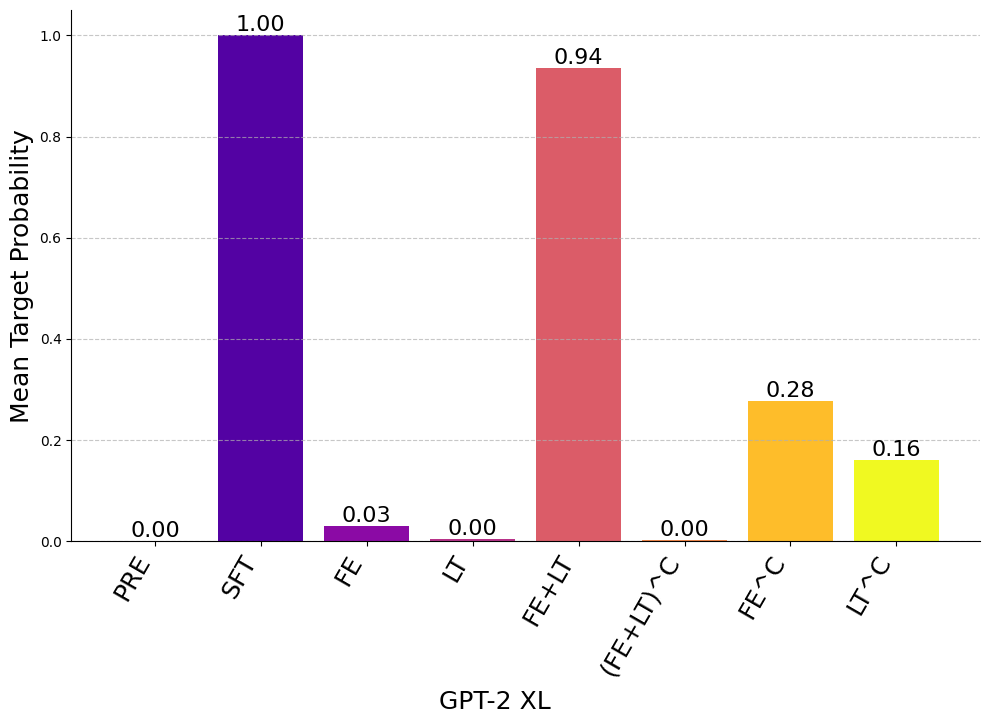

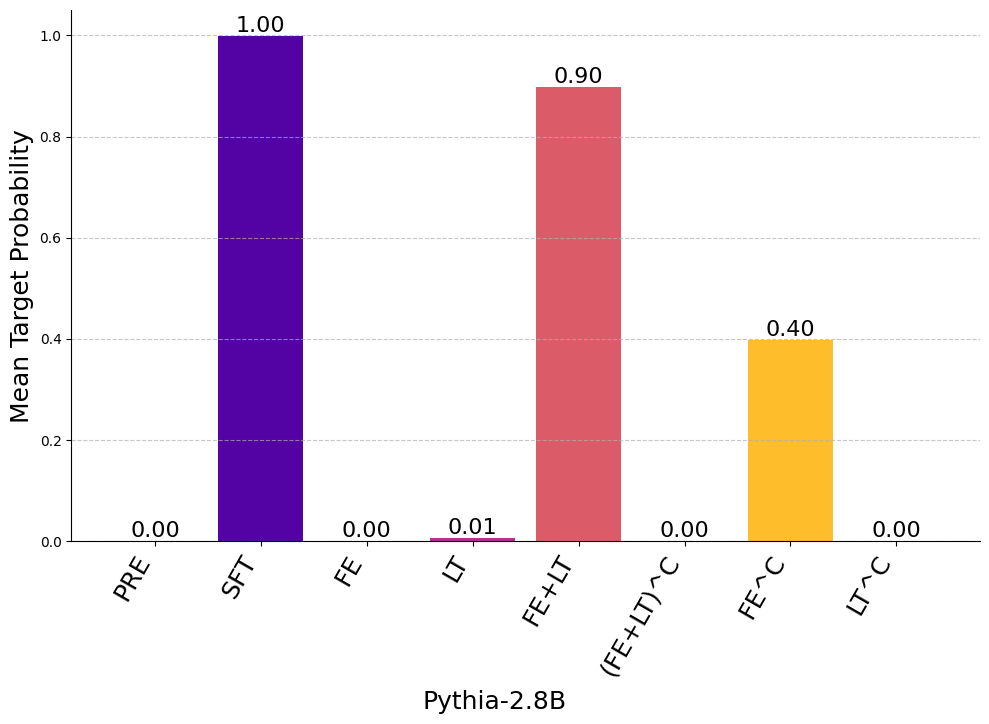

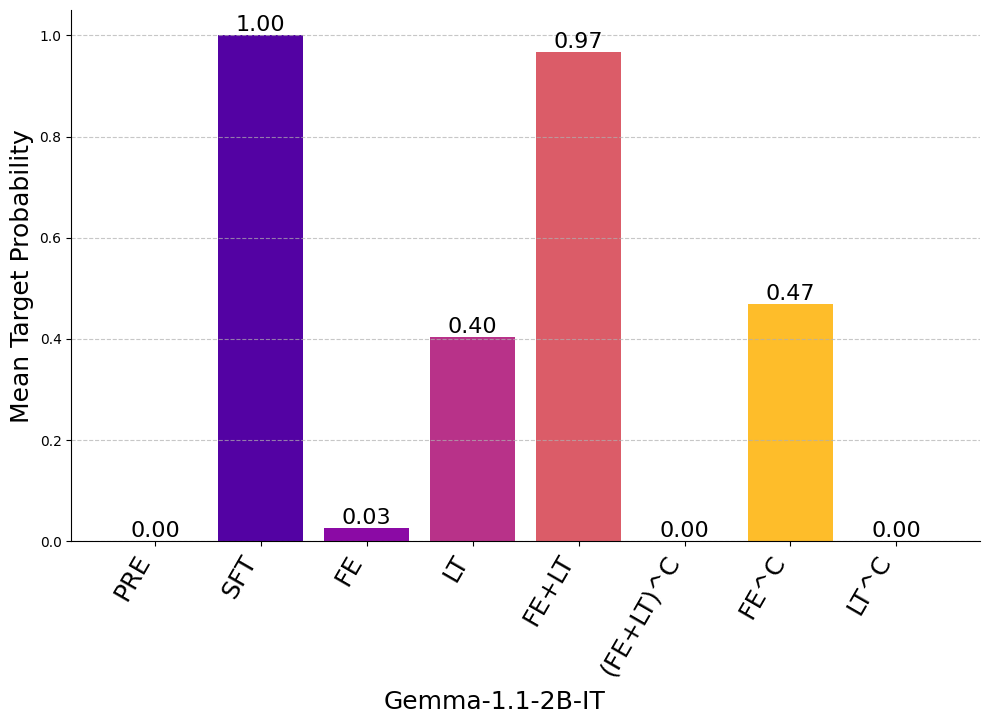

In [28]:
metric_key = "mean_target_prob"
plot_metric(organized_results, metric_key, layers_setting=layers_setting, save=save, core_patches_only=core_patches_only, short_title=short_title)

In [5]:
def prob_to_logit(p, eps=1e-9):
    # p can be a scalar or array
    p = np.clip(p, eps, 1 - eps)  # avoid log(0)
    return np.log(p) - np.log(1 - p)

In [10]:
def load_results(path):
    with open(path, "r") as f:
        data = json.load(f)
    # index by ex_id for alignment
    return {r["ex_id"]: r for r in data["results"]}

pre_path = "/net/projects/clab/tnief/knowledge-grafting/experiments_fmfa/all_layers/lm_head_never/fake_movies_fake_actors/gemma/pre2sft/no_patching/all_2025-05-03_21-41-43_best_saved_checkpoint_2025-05-24_10-49-03/sentence_1/no_patching/results.json"
patch_path = "/net/projects/clab/tnief/knowledge-grafting/experiments_fmfa/all_layers/lm_head_never/fake_movies_fake_actors/gemma/sft2pre/fe_lt/all_2025-05-03_21-41-43_best_saved_checkpoint_2025-05-24_10-49-12/sentence_1/dropout_0.0_layer_count/results.json"

def load_results(path):
    with open(path, "r") as f:
        data = json.load(f)
    # index by ex_id for alignment
    return {r["ex_id"]: r for r in data["results"]}

pre = load_results(pre_path)
patch = load_results(patch_path)

def safe_log(p, eps=1e-12):
    p = np.clip(p, eps, 1 - eps)
    return np.log(p)

target_logit_diffs = []  # per-example Δ "logit" (log-prob) for target

for ex_id, pre_res in pre.items():
    if ex_id not in patch:
        continue
    patch_res = patch[ex_id]

    # target probs from each run
    p_t_pre = pre_res["target"]["token_prob"]
    p_t_patch = patch_res["target"]["token_prob"]

    # treat log-prob as a "logit-like" value
    logit_pre = safe_log(p_t_pre)
    logit_patch = safe_log(p_t_patch)

    delta = logit_patch - logit_pre  # this is your per-example target logit difference
    target_logit_diffs.append(delta)

# Now you can look at the distribution
target_logit_diffs = np.array(target_logit_diffs)
print("Mean Δ target 'logit' (log prob) =", target_logit_diffs.mean())
print("Std  Δ target 'logit' (log prob) =", target_logit_diffs.std())

Mean Δ target 'logit' (log prob) = -0.003592501386272081
Std  Δ target 'logit' (log prob) = 0.22142777119270574


### Old Filtering Code

In [ ]:
def filter_by_sentence(data, sentence):
    # Deeply traverse the nested defaultdict structure
    filtered_data = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(dict))))
    
    for dataset, models in data.items():
        for model_type, model_dict in models.items():
            for model_name, sentence_dict in model_dict.items():
                if sentence in sentence_dict:
                    filtered_data[dataset][model_type][model_name][sentence] = sentence_dict[sentence]
    
    return filtered_data

In [ ]:
def format_result(result):
    """Format a single result as simple token-probability pairs"""
    output = []
    # Add target first with explicit label
    output.append(f"Target: {result['target']['token']}: {result['target']['token_prob']:.3f}")
    # Add top 10 predictions
    for pred in result['top_predictions'][:10]:
        output.append(f"{pred['token']}: {pred['probability']:.3f}")
    return "\n".join(output)

# Load results from the specified path
results_path = base_experiments_dir / 'lm_head_never' / 'fake_movies_real_actors' / 'gemma' / 'sft2pre' / 'not_fe' / 'all_2025-05-07_21-51-20_best_saved_checkpoint_2025-05-20_12-02-35' / 'sentence_1' / 'dropout_0.0_layer_count' / 'results.json'
results_path = Path('/net/projects/clab/tnief/knowledge-grafting/experiments/all_layers/lm_head_never/fake_movies_real_actors/gpt2-xl/sft2pre/fe_lt_complement/all_2025-05-07_21-56-24_best_saved_checkpoint_2025-05-20_12-01-54/sentence_1/dropout_0.0_layer_count/results.json')

with open(results_path, 'r') as f:
    data = json.load(f)
    results = data.get('results', [])

# Sample 5 random results
if results:
    sampled_results = random.sample(results, min(5, len(results)))
    print(f"Found {len(results)} total results. Displaying 5 random samples:\n")
    
    for i, result in enumerate(sampled_results, 1):
        print(f"Example {i}:")
        print(format_result(result))
        print("\n" + "-"*40 + "\n")
else:
    print("No results found in the specified file")